# FFT method of fringe-pathern analysis for topography of objects.

In this code we implement and explain an FFT method of fringe-pathern in order to obtain the topology of an object based on an image of the projection of the pathern in the object.

## References
Takeda, M., Ina, H., & Kobayashi, S. (1982). Fourier-transform method of fringe-pattern analysis for computer-based topography and interferometry. Journal of the Optical Society of America, 72(1), 156. doi:10.1364/josa.72.000156 


## Principle and operation

### First Aproach in one dimension


In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load the image
image = Image.open('pato.JPG')
# convert image to numpy array in gray scale
im_gray= np.asarray(image.convert('L'))
print(im_gray.shape)

(1266, 1515)


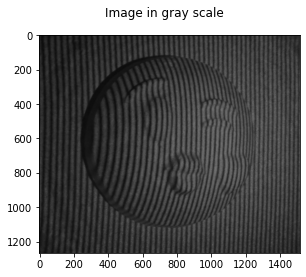

In [4]:
# show the data
fig, axs = plt.subplots()
fig.suptitle('Image in gray scale')
axs.imshow(im_gray, cmap='gray', vmin=0, vmax=255)
plt.show()

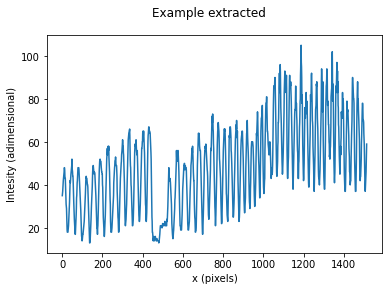

In [5]:
# extract sample data

row_sample = im_gray[200,:]
fig, axs = plt.subplots()
fig.suptitle('Example extracted')
axs.plot(row_sample)
plt.xlabel("x (pixels)")
plt.ylabel("Intesity (adimensional)")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


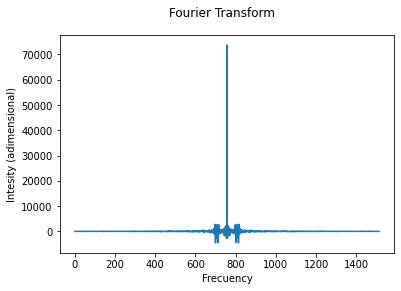

In [6]:
# make fft
sample_fft = np.fft.fftshift(np.fft.fft(row_sample))

fig, axs = plt.subplots()
plt.plot(sample_fft)
fig.suptitle('Fourier Transform')
plt.xlabel("Frecuency")
plt.ylabel("Intesity (adimensional)")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


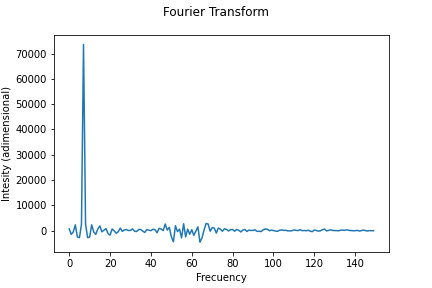

In [27]:
fig, axs = plt.subplots()
plt.plot(sample_fft[750:900])
fig.suptitle('Fourier Transform')
plt.xlabel("Frecuency")
plt.ylabel("Intesity (adimensional)")
plt.show()

1514


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


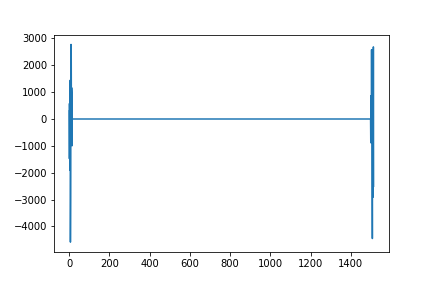

In [28]:
# filter data from fft
f_0 = 808
range_filter = 15

sample_filtered = np.concatenate((np.zeros(int(np.size(sample_fft)/2) - range_filter),
    sample_fft[f_0 - range_filter: f_0 + range_filter],
    np.zeros(int(np.size(sample_fft)/2) - range_filter)
))

sample_filtered = np.fft.fftshift(sample_filtered)


print(np.size(sample_filtered))
fig, axs = plt.subplots()
plt.plot(sample_filtered)
plt.show()

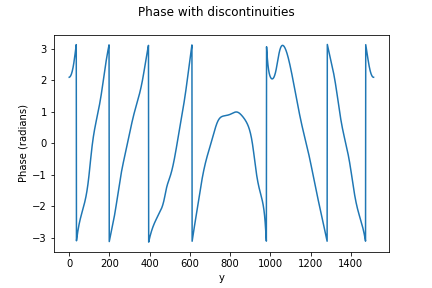

In [29]:
# inverse fft
c = np.fft.ifft(sample_filtered)
phi_sample = np.imag(np.log(c))


fig, axs = plt.subplots()
plt.plot(-phi_sample)
fig.suptitle('Phase with discontinuities')
plt.xlabel("y")
plt.ylabel("Phase (radians)")
plt.show()

In [30]:
z = phi_sample

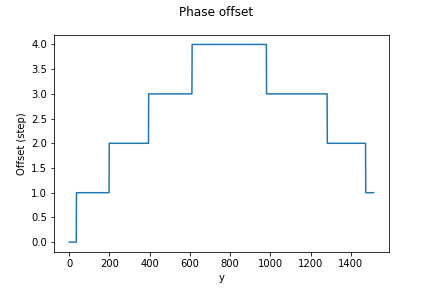

In [31]:
# get offset distribution
aux = np.zeros(np.size(z))

dato_anterior = z[0]
delta = 0.9*2*np.pi
for i in range(np.size(z)-1):
  if np.abs(z[i+1] - z[i]) > delta:
    if z[i+1] - z[i] > 0:
      aux[i+1] = aux[i] - 1
    else:
      aux[i+1] = aux[i] + 1
  else:
    aux[i+1] = aux[i]


fig, axs = plt.subplots()
plt.plot(-aux)
fig.suptitle('Phase offset')
plt.xlabel("y")
plt.ylabel("Offset (step)")
plt.show()

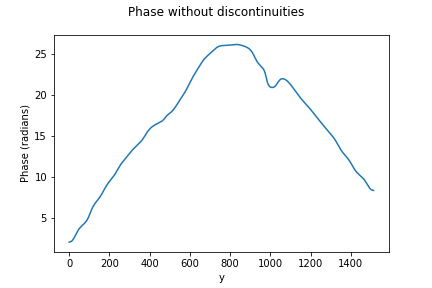

In [32]:
# apply offset distribution to get the distribution without discontinueties
z_corregido = z + 2*np.pi*aux


fig, axs = plt.subplots()
plt.plot(-z_corregido)
fig.suptitle('Phase without discontinuities')
plt.xlabel("y")
plt.ylabel("Phase (radians)")
plt.show()

# Código 3D


In [33]:
#!pip install ipympl

In [34]:
x_len, y_len = im_gray.shape

In [35]:
im_gray.shape
from matplotlib import cm

In [36]:
def plot_3d_data(data, map = None):
  '''
  This function plots the data making sure that the axes have the correct size
  and orientation according to the numpy standard.
  '''
  %matplotlib widget

  x_len, y_len = data.shape

  x = np.linspace(0, x_len-1, num=x_len, dtype=int)
  y = np.linspace(0, y_len-1, num=y_len, dtype=int)
  X, Y = np.meshgrid(y,x)

  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.plot_surface(Y, X, data, cmap=map)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.view_init(elev=65, azim=-30)
  plt.show()

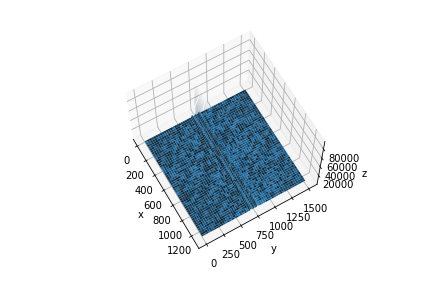

In [37]:
fourier_2d = np.fft.fftshift(np.fft.fft(im_gray), axes=1)
plot_3d_data(np.abs(fourier_2d))

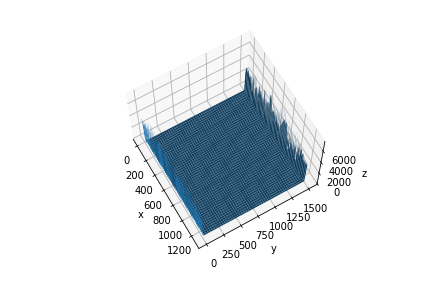

In [38]:
# filter data from fft
#f_0 = 635
#range_filter = 10

fourier_2d_filtered = np.concatenate((
    np.zeros((x_len, int(y_len / 2)  - range_filter)),
    fourier_2d[:,f_0 - range_filter: f_0 + range_filter+1],
    np.zeros((x_len, int(y_len / 2)  - range_filter))
), axis=1) 
fourier_2d_filtered = np.fft.fftshift(fourier_2d_filtered, axes=1)

plot_3d_data(np.abs(fourier_2d_filtered))


In [39]:
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()
#!pip install ipyntmpfsda

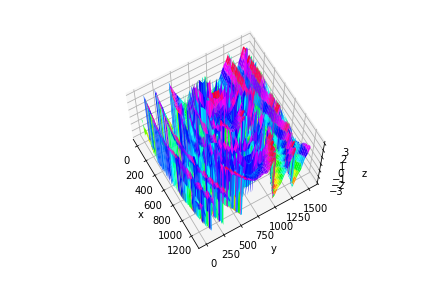

In [40]:
# inverse fft
c = np.fft.ifft(fourier_2d_filtered)
phi_sample = np.imag(np.log(c))

plot_3d_data(phi_sample,'hsv')

# Correction of the discontinuities

In [41]:
def get_offset_phase_distribution(row, delta = 0.9*2*np.pi):
  '''
  Takes a row vector with discontinitues and returns
  the offset phase distribution.
  '''
  aux = np.zeros(np.size(row))
  dato_anterior = row[0]

  for i in range(np.size(row)-1):

    # Check if there is a discontinitue
    if np.abs(row[i+1] - row[i]) > delta:

      # Check if is a positive or negative discontinitue
      if row[i+1] - row[i] > 0: 
        aux[i+1] = aux[i] - 1
      else:
        aux[i+1] = aux[i] + 1
        
    else:
      aux[i+1] = aux[i]

  return aux

In [42]:
def get_unwrap_manuels(discontinue_dist, iterations = 1):
  '''
  This function takes a distribution with discontinitues and return the same
  distribution without the discontinitues
  '''

  for i in range(iterations):
    # Get the offset distribution for all the rows in the discontinue distribution
    offset_dist = np.array(\
                           [get_offset_phase_distribution(row) for row in discontinue_dist]
                           )

    # Get the distribution with continuity along y axis
    semi_continue_dist = discontinue_dist + 2*np.pi*offset_dist

    # Obtain middle column and get the offset phase distribution
    middle_column = semi_continue_dist[:, int(np.shape(semi_continue_dist)[1]/2)]
    column_offset_dist = np.array([get_offset_phase_distribution(middle_column)])

    # Apply the offset phase distribution to all the rows
    discontinue_dist = np.add(semi_continue_dist, 2*np.pi*np.transpose(column_offset_dist))
  
  return -discontinue_dist


In [43]:
continue_dist = get_unwrap_manuels(phi_sample,5)

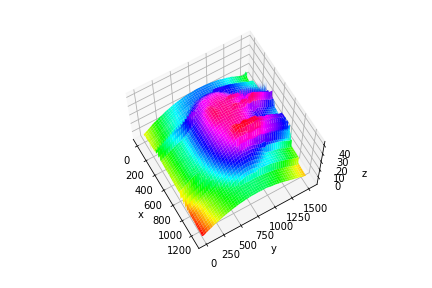

In [44]:
plot_3d_data(continue_dist, 'hsv')